In [4]:
import pandas as pd
import geopandas as gpd
from shapely import geometry as geo

import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import notebook

In [13]:
path = 'data/VNP46A2/VNP46A2.20220501.h5'
geo_path = 'data/shanghai_boundary.jspn'
savefile = 'data/NTL.csv'

data = h5py.File(path, 'r')
geo_json = gpd.read_file(geo_path)

# Open satellite NTL data in .hdf5.
gapFilled_NTL = data['HDFEOS']['GRIDS']['VNP_Grid_DNB']['Data Fields']['Gap_Filled_DNB_BRDF-Corrected_NTL']
filling = gapFilled_NTL.attrs['_FillValue']
img = gapFilled_NTL[:]
img[img==filling] = 0

n_bound =data.attrs['NorthBoundingCoord']
s_bound =data.attrs['SouthBoundingCoord']
e_bound =data.attrs['EastBoundingCoord']
w_bound =data.attrs['WestBoundingCoord']

lats = np.linspace(n_bound, s_bound, img.shape[0])
lons = np.linspace(w_bound, e_bound, img.shape[1])

# Shrink data by a locations box.
shanghai_bound = [120, 122.5, 30.6, 32]
img = img[(lats>shanghai_bound[2]) & (lats<shanghai_bound[3]), :]
img = img[:, (lons>shanghai_bound[0]) & (lons<shanghai_bound[1])]

lats = np.linspace(shanghai_bound[3], shanghai_bound[2], img.shape[0])
lons = np.linspace(shanghai_bound[0], shanghai_bound[1], img.shape[1])
lons,lats = np.meshgrid(lons, lats)

# Convert to 1-D array.
img = img.reshape(img.size)
lats = lats.reshape(lats.size)
lons = lons.reshape(lons.size)

# Shrink data by NTL value threshold.
TH = 1
lats = lats[img>TH]
lons = lons[img>TH]
img = img[img>TH]

# Build pandas dataframe.
df_ntl = pd.DataFrame({'NTL': img, 'lats':lats, 'lons':lons})
df_ntl['geometry']=df_ntl.apply(lambda x: geo.Point(x.lons,x.lats),axis=1)

# Calculate intersections.
flag = []
for pt in notebook.tqdm(df_ntl['geometry']):
    tmp_flag = False
    for mpolygon in geo_json['geometry']:
        if mpolygon.intersects(pt):
            tmp_flag = True
            break
    flag.append(tmp_flag)
df_ntl = df_ntl[flag]

# Save as .csv
df_ntl.to_csv(savefile, encoding='utf_8_sig', index=None)

E:\env\conda\envs\bigdata\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


  0%|          | 0/138864 [00:00<?, ?it/s]

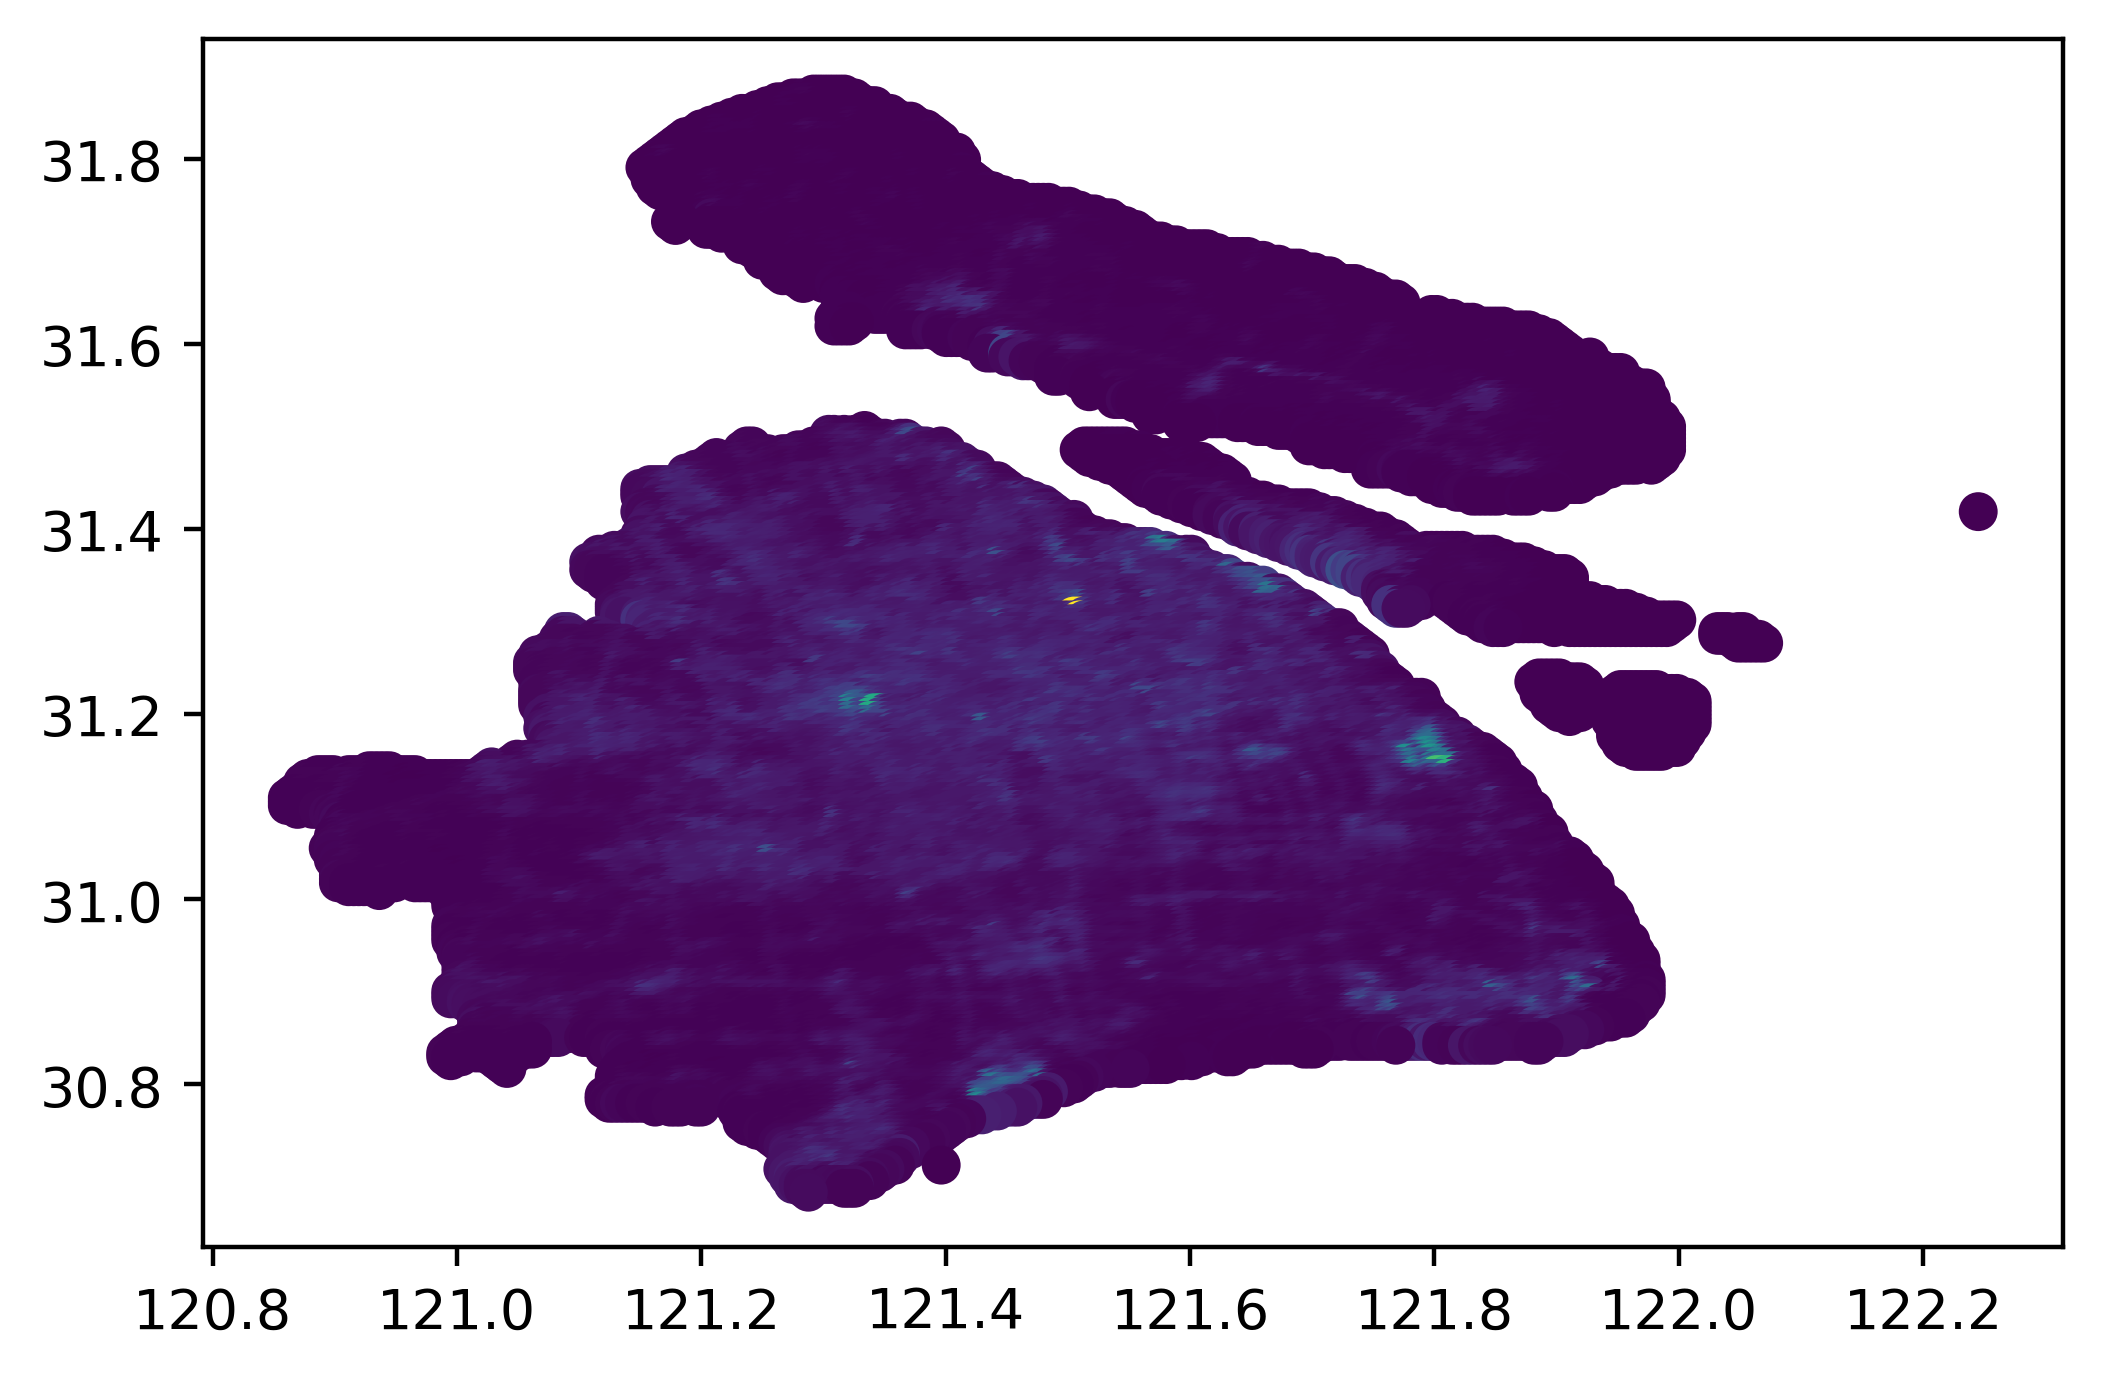

In [14]:
lats = df_ntl['lats']
lons = df_ntl['lons']
img = df_ntl['NTL']

plt.figure(dpi=400)
plt.scatter( lons, lats, c=img)
plt.show()